In [5]:

from stock_prediction import ARIMAXGBoost
from stock_prediction.core import GradientDescentRegressor

In [6]:
# # -*- coding: utf-8 -*
# import pandas as pd
# import numpy as np
# test = pd.read_csv("/Users/jamie/Downloads/kaggle/test.csv")
# train = pd.read_csv("/Users/jamie/Downloads/kaggle/train.csv")
# sample_submission = pd.read_csv("/Users/jamie/Downloads/kaggle/sample_submission.csv")


In [7]:
# test

In [8]:
# train

In [9]:
# from sklearn.model_selection import train_test_split
# from skopt import BayesSearchCV
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from skopt.space import Real, Integer, Categorical
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import make_scorer

# # Define the model
# model = GradientDescentRegressor()
# # Define the search space
# params =  {"n_iter": Integer(200,1200),
#            "lr": Real(0.01,0.5),
#            "alpha": Real(0.0001, 0.1),
#            "l1_ratio": Real(0.0001, 0.1),
#            "momentum": Real(0.5, 0.95),
#         #     "batch_size": Integer(32, 256),
#             "rmsprop": Categorical([True, False]),
# }

# # Define the BayesSearchCV object
# # Introduce the new metric RMSLE
# # def rmsle(y_true, y_pred):
# #     return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))))


# # Revise the RMSLE function to clip predictions
# def rmsle(y_true, y_pred):
#     y_pred = np.clip(y_pred, a_min=1e-7, a_max=None)  # Prevent log(negative)
#     return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

# # Get the best score
# search = BayesSearchCV(
#     model,
#     params,
#     # n_iter=int(10),
#     scoring=make_scorer(rmsle, greater_is_better=False),
#     cv=5,
#     n_jobs=-1,
#     error_score='raise',
#     random_state=42,
# )


# # Feature engineering
# train["Sex"] = (train["Sex"]=="male").astype(int)
# test["Sex"] = (test["Sex"] == "male").astype(int)
               
# # need standardization
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = train.drop(columns=['Calories', 'id'])
# X_train = scaler.fit_transform(X_train)
# y_train = train['Calories'].values

# X_test = test.drop(columns=['id'])
# X_test = scaler.transform(X_test)




In [10]:

# # Fit the model with entire labelled data
# search.fit(X_train, y_train) #search is the model
# # Get the best parameters
# best_params = search.best_params_
# print("Best parameters: ", best_params)
# # Get the best score
# best_score = search.best_score_
# print("Best score: ", best_score)

In [11]:
# search.best_estimator_.predict(X_test)
# submission = pd.DataFrame({
#     "id": test["id"],
#     "Calories": search.best_estimator_.predict(X_test)
# })
# submission.to_csv("submission.csv", index=False)
# print("Submission saved to submission.csv")
# submission

In [12]:
# (search.best_estimator_.predict(X_test) < 0).sum()

In [13]:
# sample_submission

In [14]:
# search.cv_results_

In [15]:
from stock_prediction import StockPredictor
stock = StockPredictor("CRWD", "2010-01-01")
stock.load_data()


X =  stock.data.drop(columns="Close")
y = stock.data["Close"]
train_pct_index = int(0.7 * len(stock.data))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((867, 40), (867,), (372, 40), (372,))

In [17]:
# Ensure the n_epoches is fixed
n_epochs = 10000

In [18]:
# Import various optimizers
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
# Nesterov
vanilla_sgd = SGDRegressor(loss='squared_error', penalty='elasticnet',random_state=42, verbose=10000,
                           learning_rate='constant', eta0=0.01, alpha=0.0001, l1_ratio=0.5,
                           n_iter_no_change=10,  validation_fraction=0.1,)
# Track loss manually
vanilla_sgd_loss_history = []
counter = 0
for _ in range(n_epochs):
    vanilla_sgd.partial_fit(X_train, y_train)  # Train for one epoch
    y_pred = vanilla_sgd.predict(X_train)
    loss = mean_squared_error(y_train, y_pred)
    vanilla_sgd_loss_history.append(loss)
    counter += 1
    print(f"Epoch {counter}")
  
# Fit the model with entire labelled data
# vanilla_sgd = SGDRegressor(loss='squared_error', random_state=42, verbose=10000)  
# vanilla_sgd.fit(X_train, y_train)



-- Epoch 1
Norm: 17.06, NNZs: 39, Bias: 175.275390, T: 867, Avg. loss: 1151.118234
Total training time: 0.00 seconds.
Epoch 1
-- Epoch 1
Norm: 17.32, NNZs: 39, Bias: 175.091834, T: 867, Avg. loss: 3.509835
Total training time: 0.00 seconds.
Epoch 2
-- Epoch 1
Norm: 17.70, NNZs: 39, Bias: 175.035632, T: 867, Avg. loss: 2.663546
Total training time: 0.00 seconds.
Epoch 3
-- Epoch 1
Norm: 18.04, NNZs: 39, Bias: 175.021209, T: 867, Avg. loss: 2.409330
Total training time: 0.00 seconds.
Epoch 4
-- Epoch 1
Norm: 18.36, NNZs: 39, Bias: 175.019176, T: 867, Avg. loss: 2.260733
Total training time: 0.03 seconds.
Epoch 5
-- Epoch 1
Norm: 18.67, NNZs: 39, Bias: 175.021137, T: 867, Avg. loss: 2.159553
Total training time: 0.00 seconds.
Epoch 6
-- Epoch 1
Norm: 18.95, NNZs: 39, Bias: 175.024561, T: 867, Avg. loss: 2.086147
Total training time: 0.00 seconds.
Epoch 7
-- Epoch 1
Norm: 19.22, NNZs: 39, Bias: 175.028382, T: 867, Avg. loss: 2.030850
Total training time: 0.00 seconds.
Epoch 8
-- Epoch 1
No

KeyboardInterrupt: 

In [ ]:

import numpy as np
# # model2 is selected by Bayesian optimization CV (Seems not good)
# model2 = GradientDescentRegressor(alpha = 0.04106938548944606,
#                 batch_size = 195,
#                 l1_ratio = 0.09329351308489861,
#                 lr = 0.1647418008086539,
#                 momentum = 0.8015665767210205,
#                 # n_iter = 614,
#                 n_iter = 5000,
#                 random_state = 42,
#                 rmsprop = True
#                 )
# model2.fit(X_train, y_train)


# # model3 is model used in the arimaxgboost
# model3 = GradientDescentRegressor(
#             # n_iter=1000,
#             n_iter = 5000,
#             lr=0.05,
#             alpha=0.01,
#             l1_ratio=0.01,
#             momentum=0.9,
#             rmsprop=False,
#             random_state=42,
#             # early_stopping=True,
#         )
# model3.fit(X_train, y_train)


# # model4 is rmsprop = True version of model3
# model4 = GradientDescentRegressor(
#             # n_iter=1000,
#             n_iter = 5000,
#             lr=0.05,
#             alpha=0.01,
#             l1_ratio=0.01,
#             momentum=0.9,
#             rmsprop=True,
#             random_state=42,
#             # early_stopping=True,
#         )
# model4.fit(X_train, y_train)


# default model without any tuning (with more iterations for illustration)
model5 = GradientDescentRegressor(
            n_iter=n_epochs,
            rmsprop=False,
            random_state=42,
        )
model5.fit(X_train, y_train)


GradientDescentRegressor(n_iter=10000)

In [ ]:
model5.get_params()

{'alpha': 0.0001,
 'batch_size': None,
 'early_stopping': False,
 'l1_ratio': 0.0001,
 'lr': 0.01,
 'momentum': 0.9,
 'n_iter': 10000,
 'newton': False,
 'random_state': 42,
 'rmsprop': False}

In [ ]:

# # Start from default model and use optimization
# model6 = GradientDescentRegressor(
#             n_iter=n_epochs,
#             rmsprop=False,
#             random_state=42,
#         )
# _ = model6.optimize_hyperparameters(X_train, y_train, n_iter=500)
# print(_)
# # print(f"GD model parameters: { {k: model6.__dict__[k] for k in list(model6.__dict__.keys())[:8]}}"
# #             )
# model6.fit(X_train, y_train)

# loss_history2 = np.array(model2.loss_history)
# mse_history2 = np.array(model2.mse_history)
# # coef_history2 = np.array(model2.coef_history)
# # grad_history2 = np.array(model2.grad_history)

# loss_history3 = np.array(model3.loss_history)
# mse_history3 = np.array(model3.mse_history)
# # coef_history3 = np.array(model3.coef_history)
# # grad_history3 = np.array(model3.grad_history)

# loss_history4 = np.array(model4.loss_history)
# mse_history4 = np.array(model4.mse_history)
# # coef_history4 = np.array(model4.coef_history)
# # grad_history4 = np.array(model4.grad_history)

loss_history5 = np.array(model5.loss_history)
mse_history5 = np.array(model5.mse_history)
coef_history5 = np.array(model5.coef_history)
grad_history5 = np.array(model5.grad_history)

# loss_history6 = np.array(model6.loss_history)
# mse_history6 = np.array(model6.mse_history)
# # coef_history6 = np.array(model6.coef_history)
# # grad_history6 = np.array(model6.grad_history)

from matplotlib import pyplot as plt


In [ ]:
# loss_history2-mse_history2

In [ ]:
# loss_history3-mse_history3

In [ ]:
# loss_history4-mse_history4

In [ ]:
# mse_diff = (mse_history2 - mse_history3)

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# chart = pd.DataFrame({
#     "Epoch": np.arange(len(loss_history)),
#     "Coef": loss_history,
#     "Coef_": mse_history,
# })

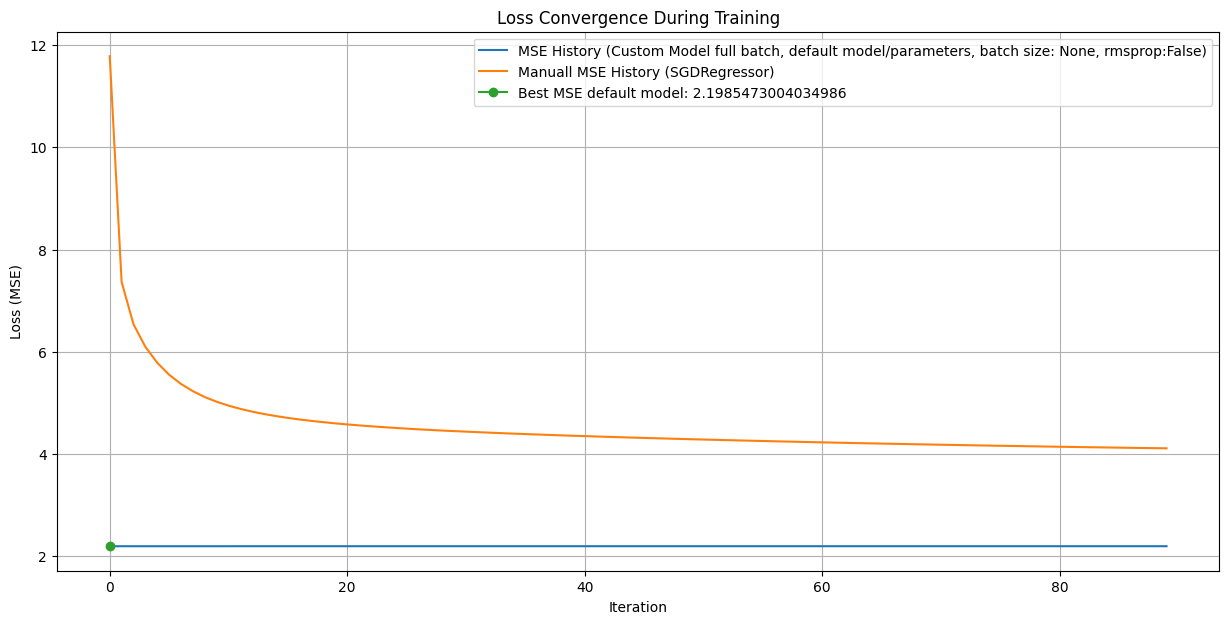

In [ ]:
# matches the way of calculating loss 
plt.figure(figsize=(15, 7))
start = 0
end = 90
# plt.plot(range(start,end),mse_history2[start:end], label=f'MSE History (Custom Model mini-batch, batch size:{model2.batch_size}, rmsprop:{model2.rmsprop})')
# plt.plot(range(start,end),mse_history3[start:end], label=f'MSE History (Custom Model full batch, batch size: {model3.batch_size}, rmsprop:{model3.rmsprop})')
# plt.plot(range(start,end),mse_history4[start:end], label=f'MSE History (Custom Model full batch, batch size: {model4.batch_size}, rmsprop:{model4.rmsprop})')
plt.plot(range(start,end),mse_history5[start:end], label=f'MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
# plt.plot(range(start,end),mse_history6[start:end], label=f'MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')
plt.plot(range(start,end), np.array(vanilla_sgd_loss_history)[start:end], label='Manuall MSE History (SGDRegressor)')

plt.plot(np.argmin(mse_history5), mse_history5[np.argmin(mse_history5)], marker = 'o', label='Best MSE default model: {}'.format(mse_history5[np.argmin(mse_history5)]))
# plt.plot(np.argmin(mse_history6), mse_history6[np.argmin(mse_history6)], marker = 'o', label='Best MSE optimized model: {}'.format(mse_history6[np.argmin(mse_history6)]))
    
if start <= np.argmin(vanilla_sgd_loss_history) <= end:
   plt.plot(np.argmin(vanilla_sgd_loss_history), np.array(vanilla_sgd_loss_history).min(), 'ro', label='Best MSE SGDRegressor: {}'.format(np.array(vanilla_sgd_loss_history).min()))
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Loss Convergence During Training")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Want to see TEST loss over epochs
test_vanilla_sgd_loss_history = []
test_vanilla_sgd = SGDRegressor(loss='squared_error', penalty='elasticnet',random_state=42, verbose=10000,
                            learning_rate='constant', eta0=0.01, alpha=0.0001, l1_ratio=0.0001)
counter = 0
for _ in range(n_epochs):
     # Test for one epoch
    test_vanilla_sgd.partial_fit(X_train, y_train)  # Train for one epoch
    y_pred =  test_vanilla_sgd.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    test_vanilla_sgd_loss_history.append(loss)
    counter += 1
    print(f"Epoch {counter}")


test_model5 = GradientDescentRegressor(
            n_iter=n_epochs,
            rmsprop=False,
            random_state=42,
        )
test_model5._fit_gd(X_train, y_train, X_test, y_test)
test_mse_history5 = np.array(test_model5.val_mse_history)
mse_history5 = np.array(test_model5.mse_history)


# test_model6 = GradientDescentRegressor(
#             n_iter=n_epochs,
#             rmsprop=False,
#             random_state=42,
#         )
# _ = test_model6.optimize_hyperparameters(X_train, y_train,n_iter=500)
# print(_)
# test_model6._fit_gd(X_train, y_train, X_test, y_test)
# test_mse_history6 = np.array(test_model6.val_mse_history)
# mse_history6 = np.array(test_model6.mse_history)


  


-- Epoch 1
Norm: 17.05, NNZs: 39, Bias: 175.275319, T: 867, Avg. loss: 1151.116397
Total training time: 0.00 seconds.
Epoch 1
-- Epoch 1
Norm: 17.31, NNZs: 39, Bias: 175.091744, T: 867, Avg. loss: 3.510188
Total training time: 0.00 seconds.
Epoch 2
-- Epoch 1
Norm: 17.69, NNZs: 39, Bias: 175.035558, T: 867, Avg. loss: 2.664254
Total training time: 0.00 seconds.
Epoch 3
-- Epoch 1
Norm: 18.03, NNZs: 39, Bias: 175.021138, T: 867, Avg. loss: 2.410361
Total training time: 0.00 seconds.
Epoch 4
-- Epoch 1
Norm: 18.36, NNZs: 39, Bias: 175.019022, T: 867, Avg. loss: 2.262055
Total training time: 0.00 seconds.
Epoch 5
-- Epoch 1
Norm: 18.66, NNZs: 39, Bias: 175.020980, T: 867, Avg. loss: 2.160874
Total training time: 0.00 seconds.
Epoch 6
-- Epoch 1
Norm: 18.94, NNZs: 39, Bias: 175.024355, T: 867, Avg. loss: 2.087471
Total training time: 0.00 seconds.
Epoch 7
-- Epoch 1
Norm: 19.20, NNZs: 39, Bias: 175.028145, T: 867, Avg. loss: 2.032218
Total training time: 0.00 seconds.
Epoch 8
-- Epoch 1
No

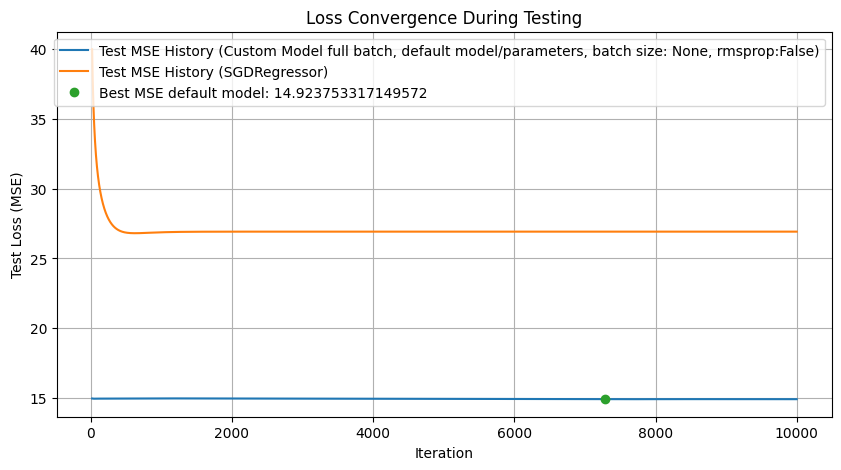

In [ ]:
plt.figure(figsize=(10, 5))
start = 20
end = 10000
plt.plot(range(start,end),test_mse_history5[start:end], label=f'Test MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
# plt.plot(range(start,end),test_mse_history6[start:end], label=f'Test MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')
plt.plot(range(start,end), np.array(test_vanilla_sgd_loss_history)[start:end], label='Test MSE History (SGDRegressor)')

# if start <= np.argmin(test_vanilla_sgd_loss_history) <= end:
#    plt.plot(np.argmin(test_vanilla_sgd_loss_history), np.array(test_vanilla_sgd_loss_history).min(), 'o', label='Best MSE SGDRegressor: {}'.format(np.array(test_vanilla_sgd_loss_history).min()))
plt.plot(np.argmin(test_mse_history5), test_mse_history5.min(), 'o', label='Best MSE default model: {}'.format(test_mse_history5[np.argmin(test_mse_history5)]))
# plt.plot(np.argmin(test_mse_history6), test_mse_history6.min(), 'ro')
plt.xlabel("Iteration")
plt.ylabel("Test Loss (MSE)")
plt.title("Loss Convergence During Testing")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Find global minima and maxima indexes
import pandas as pd

np.argmin(test_mse_history5) 



7290

In [ ]:
np.argmin(mse_history5) # train

0

In [ ]:
np.argmin(vanilla_sgd_loss_history)

885

In [ ]:
np.argmin(np.array(test_vanilla_sgd_loss_history))


628

In [ ]:
min(test_mse_history5), min(test_vanilla_sgd_loss_history)

(14.923753317149572, 26.80718104165866)

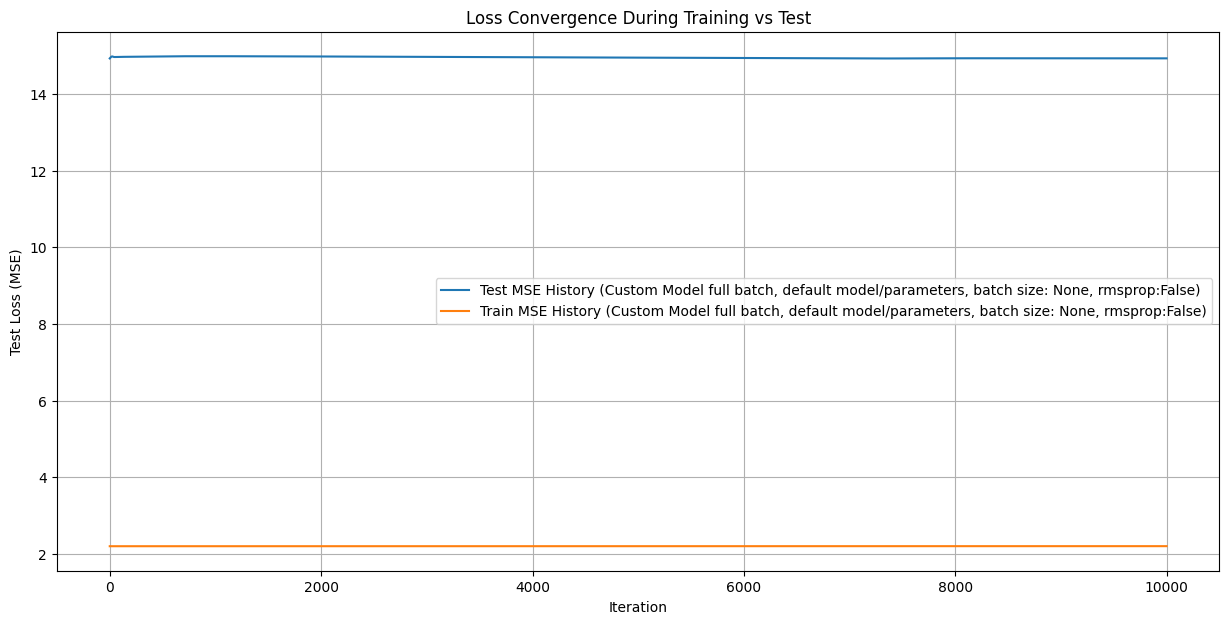

In [ ]:
plt.figure(figsize=(15, 7))
start = 0
end = 10000
plt.plot(range(start,end),test_mse_history5[start:end], label=f'Test MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')
plt.plot(range(start,end),mse_history5[start:end], label=f'Train MSE History (Custom Model full batch, default model/parameters, batch size: {model5.batch_size}, rmsprop:{model5.rmsprop})')

# plt.plot(range(start,end),mse_history6[start:end], label=f'Train MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')
# plt.plot(range(start,end),test_mse_history6[start:end], label=f'Test MSE History (Custom Model full batch, optimized parameters, batch size: {model6.batch_size}, rmsprop:{model6.rmsprop})')

# plt.plot(range(start,end), np.array(vanilla_sgd_loss_history)[start:end], label='Train MSE History (SGDRegressor)')
# plt.plot(range(start,end), np.array(test_vanilla_sgd_loss_history)[start:end], label='Test MSE History (SGDRegressor)')

# if start <= np.argmin(mse_history5) <= end and  start <= np.argmin(test_mse_history5) <= end:
#     plt.plot(np.argmin(mse_history5), mse_history5[np.argmin(mse_history5)], marker='o')
#     plt.plot(np.argmin(test_mse_history5), test_mse_history5[np.argmin(test_mse_history5)], marker='o')

# if start <= np.argmin(mse_history6) <= end and  start <= np.argmin(test_mse_history6) <= end:
#     plt.plot(np.argmin(mse_history6), mse_history6[np.argmin(mse_history6)], marker='o')
#     plt.plot(np.argmin(test_mse_history6), test_mse_history6[np.argmin(test_mse_history6)], marker='o') 

# if start <= np.argmin(vanilla_sgd_loss_history) <= end and  start <= np.argmin(np.array(test_vanilla_sgd_loss_history)) <= end:
#     plt.plot(np.argmin(vanilla_sgd_loss_history),vanilla_sgd_loss_history[np.argmin(vanilla_sgd_loss_history)], 'ro')
#     plt.plot(np.argmin(np.array(test_vanilla_sgd_loss_history)), np.array(test_vanilla_sgd_loss_history).min(), 'ro')
plt.xlabel("Iteration")
plt.ylabel("Test Loss (MSE)")
plt.title("Loss Convergence During Training vs Test")
plt.legend()
plt.grid(True)
plt.show()


## Note: 
- No need to get RMSprop for full batch as it fluctuates while the loss function is always lower for ones without RMSprop.
- It is necessary to have rmsprop for mini-batch and stochastic gd.
- Mini-batch/s trade efficiency by accuracy.

In [ ]:


# x0 = np.array([[45.],[-15.]])
# x_ = tt(x0, requires_grad=True)
# A_ = tt(A)
# A_inv_ = tt(A_inv)
# b_ = tt(b)

# f = L2_X
# # f = squared_L2_X
# # f = mahalanobis_X
# # f = squared_mahalanobis_X # f = lambda X: squared_mahalanobis_X(X, l1_lambda=50)
# def f_(x_, mahalanobis=True, square=True, l1_lambda=0):
#     M = A_@x_-b_
#     if mahalanobis:
#          M = M.T@A_inv_@M + l1_lambda*torch.abs(x_).sum()
#     else:
#         M = M.T@M
#     if square:
#         return M
#     return M**0.5

# K = 150
# xs = np.zeros((2,K+1))
# xs[:,0] = x0.flatten()
# alpha = 0.023

# momentum = True
# decay = 0.75
# direction = 0
# RMSprop = False
# r = 0.1
# directions_squared = 0
# Newtons = False

# for k in range(K):

#     cost = f_(x_)

#     cost.backward()
#     # defines x.grad of all prior computations

#     # do no count these computations towards the gradient
#     with torch.no_grad():

#         if momentum:

#             direction = decay*direction + x_.grad

#         elif RMSprop:

#             directions_squared = r*directions_squared + (1-r)*(x_.grad*x_.grad)
#             direction = decay*direction + x_.grad/directions_squared**0.5

#         else:

#             direction = x_.grad

#         if Newtons:
#             # A_inv_@/2 for f_(x_, mahalanobis=True, square=True)
#             x_.data -= torch.linalg.solve(torch.func.hessian(f_)(x_).reshape(2,2),
#                                           direction)
#         else:
#             x_.data -= alpha*direction


#     x_.grad.zero_()

#     xs[:,k+1] = x_.detach().numpy().flatten()


# plt.contour(x1, x2, f(X).reshape(n0,n0))
# for k in range(K):
#      plt.plot(xs[0,k:(k+2)], xs[1,k:(k+2)], color='k', alpha=0.5)
#      plt.plot(xs[0,k+1], xs[1,k+1], 'o', color='r', alpha=0.5)


In [89]:
from stock_prediction.core import GradientDescentRegressor
import numpy as np
import matplotlib.pyplot as plt
model5_2D =  GradientDescentRegressor(
            n_iter=n_epochs,
            rmsprop=False,
            random_state=42,
        )
X_train_2D = X_train[:, 1:2]  # Use only the first feature for 2D visualization
model5_2D.fit(X_train_2D, y_train)
model5_2D.coef_history = np.array(model5_2D.coef_history)
            
            
    




from mpl_toolkits.mplot3d import Axes3D
# Create 3D plot
X_b = np.c_[np.ones((len(X_train_2D), 1)), X_train_2D[:,0]]  # add x0 = 1 to each instance
# contour plot
theta0 = np.linspace(175.4, 175.5, 100)
theta1 = np.linspace(23, 23.2, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0, theta1)

J_vals = np.zeros((len(theta0), len(theta1)))
cost_function = lambda X, y, theta: np.mean((X @ theta - y) ** 2) 



for i, t0 in enumerate(theta0_grid):
    for j, t1 in enumerate(theta1_grid):
        # print(np.array([t0, t1]).reshape(2,1).shape)
        J_vals[i, j] = cost_function(X_b, np.array(y_train).reshape(-1,1), np.array([[t0, t1]]).T)
        # J_vals[i, j] = L2_x(X_b, np.array([[t0, t1]]).T)
        
# plt.contour(
#     theta0, theta1, 
#             J_vals, 
#             # cost_function(X_b, np.array(y_train).reshape(-1,1), np.array([[theta0, theta1]]).T),
#             # levels=np.logspace(-2, 3, 20)
#             )


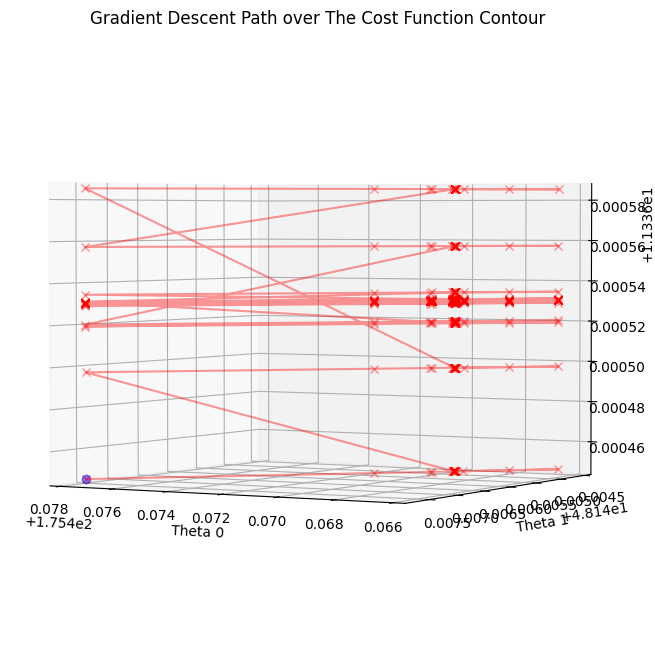

In [103]:

# Plot surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(X= theta0_grid, Y= theta1_grid, Z =J_vals, 
#                       cmap='viridis', alpha=0.8,
#                       linewidth=0, antialiased=True)
# annotate the value of the contour
# plt.clabel(plt.contour(theta0, theta1, J_vals, levels=20), inline=True, fontsize=8)

theta_history = np.array(model5_2D.coef_history[:5000:10]) # only get the second column (THE FIRST COLUMN IS THE INTERCEPT)
# plot the arrow of the direction
# for k in range(K):
#      plt.plot(xs[0,k:(k+2)], xs[1,k:(k+2)], color='k', alpha=0.5)
#      plt.plot(xs[0,k+1], xs[1,k+1], 'o', color='r', alpha=0.5)

# calcullate the cost value of the theta history
z_vals = np.zeros((len(theta_history), 1))
for i, (t0, t1) in enumerate(zip(theta_history[:,0], theta_history[:,1])):
    z_vals[i] = cost_function(X_b, np.array(y_train).reshape(-1,1), np.array([[t0, t1]]).T)


# Set viewing angle
ax.view_init(elev=2, azim=120)
# the path is taken by gradient descent on the contour plot

# for k in range(K):
#      plt.plot(xs[0,k:(k+2)], xs[1,k:(k+2)], color='k', alpha=0.5)
#      plt.plot(xs[0,k+1], xs[1,k+1], 'o', color='r', alpha=0.5)
# for i in range(len(theta_history)-1):
#     ax.plot([theta_history[i,0], theta_history[i+1,0]],
#             [theta_history[i,1], theta_history[i+1,1]],
#             [z_vals[i], z_vals[i+1]], 'o', color='r', alpha=0.5)
#     ax.plot(theta_history[i:i+2,0], theta_history[i:i+2,1], z_vals[i:i+2], color='k', alpha=0.4)
first = theta_history[0]
last = theta_history[-1]
ax.plot([first[0]], [first[1]], [z_vals[0]], marker='o', color='b', alpha=0.5, label="Gradient Descent Path")
ax.plot([last[0]], [last[1]], [z_vals[-1]], marker='o', color='black', alpha=1, label="Gradient Descent Path")

ax.plot(theta_history[:,0], theta_history[:,1], z_vals,  marker='x', color='r', alpha=0.4, label="Gradient Descent Path")   
plt.title("Gradient Descent Path over The Cost Function Contour")
plt.xlabel("Theta 0")
plt.ylabel("Theta 1")
plt.show()


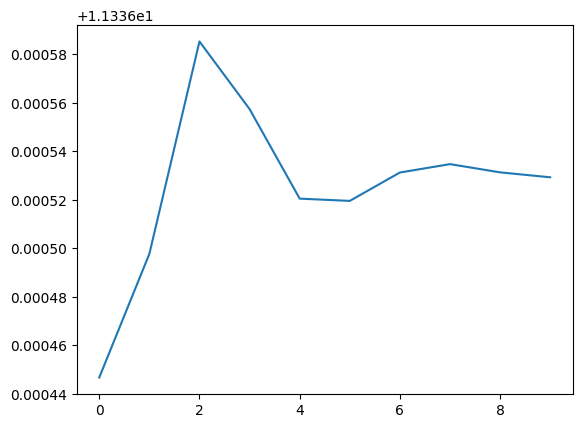

In [106]:
plt.plot(z_vals[:10])

In [105]:
theta_history[0]

array([175.47756875,  48.14768935])

In [93]:
min(theta_history[:,0]), max(theta_history[:,0])

(175.46639948217359, 175.47756874560264)

In [94]:
min(theta_history[:,1]), max(theta_history[:,1])

(48.14457879777378, 48.14768935450491)

In [95]:
theta_history[:,1],

(array([48.14768935, 48.14582157, 48.1445788 , 48.14491445, 48.14543302,
        48.14544767, 48.14527058, 48.1452205 , 48.14526953, 48.14529944,
        48.14528994, 48.1452771 , 48.14527715, 48.14528164, 48.14528277,
        48.14528148, 48.14528077, 48.14528103, 48.14528135, 48.14528134,
        48.14528122, 48.1452812 , 48.14528123, 48.14528125, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.14528124, 48.14528124,
        48.14528124, 48.14528124, 48.14528124, 48.1

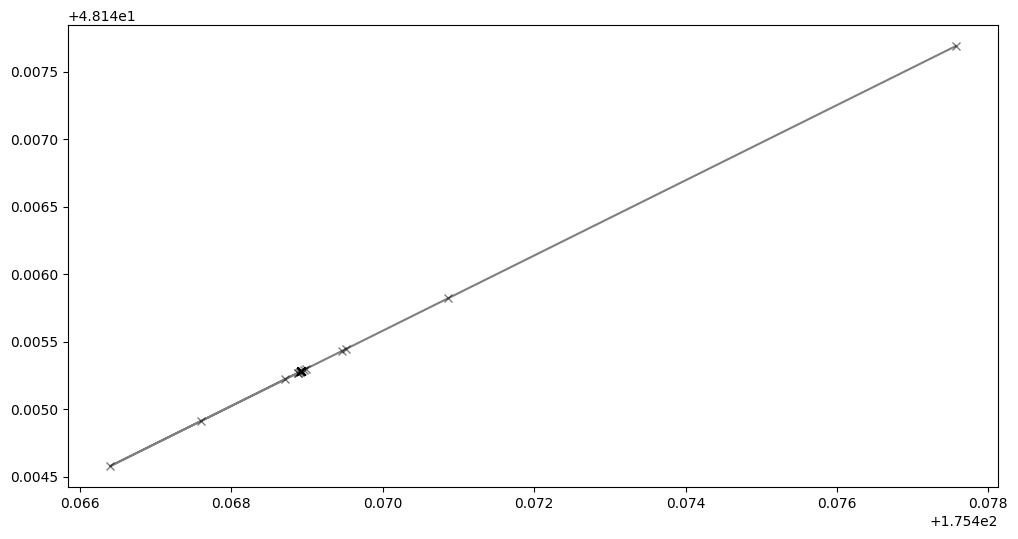

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(theta_history[:,0], theta_history[:,1], marker='x', color='k', alpha=0.5)

In [97]:
np.array(model5.coef_history)[:,10]

NameError: name 'model5' is not defined

In [ ]:
np.array(model5.grad_history)[:,1]

array([1.84304123e-03, 1.67105409e-03, 1.49151404e-03, ...,
       6.62353969e-05, 6.62109579e-05, 6.61908668e-05])

In [ ]:
X_train.shape

(867, 40)

In [ ]:
theta0.shape, theta1.shape, J_vals.shape

((100,), (100,), (100, 100))

In [ ]:

X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train[:,0]]  # add x0 = 1 to each instance
for i, t0 in enumerate(theta0):
    for j, t1 in enumerate(theta1):
        print((X_b @ np.array([[t0, t1]]).T).shape)

(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(867, 1)
(

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((867, 40), (867,), (372, 40), (372,))

In [ ]:
X_b.shape, y_train.shape, np.array([[t0, t1]]).shape

((867, 2), (867,), (1, 2))

In [ ]:
y_train.shape

(867,)

In [ ]:
for theta in theta_history:
    print(theta[:2].shape)

(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
